In [1]:
local = False

In [2]:
if not local:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
if not local:
    %cd /content/drive/MyDrive/Sun/ML Shock/Final project/

/content/drive/MyDrive/Sun/ML Shock/Final project


# Convolutional Neural Networks


In [4]:
import sys
if local:
    sys.path.insert(0,"C:/Users/Amy/Desktop/Green_Git/eegClassification/utils")
else:
    sys.path.insert(0,"/content/drive/MyDrive/Sun/ML Shock/Final project/")

In [5]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToPILImage

from CustomDataLoaderNPY import CustomDataset
from torch.utils.data import DataLoader
from model_architectures import CustomCNN, TransNet_Resnet18, TransNet_Efficientnetb0

import os

In [6]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    print("GPU count", torch.cuda.device_count())

CUDA is available!  Training on GPU ...
GPU count 1


---
## Load the Data

In [7]:
# Load (train or test) data from csv file
if local:
    path = "C:/Users/Amy/Desktop/Green_Git/eegClassification/sample_data/"
    path_df = "C:/Users/Amy/Desktop/Green_Git/eegClassification/files/"
else:
    path = "./data_prep_all_spec/"
    path_df = "./"


In [8]:
# Type of input data
data_type = "spec" # "eeg_raw" #"eeg_spec"  #
# number of subprocesses to use for data loading
import multiprocessing as cpu
num_workers = 0 #cpu.cpu_count() #- 1
# how many samples per batch to load
batch_size = 64


In [9]:
if data_type == "spec":
    input_shape = (3,400,299)
elif data_type == "eeg_spec":
    input_shape = (20,129,43)
elif data_type == "eeg_raw":
    input_shape = (20,9800)

In [10]:
data_path = path+'train/'
N_items = len(os.listdir(data_path)) // 2
print("Number of items", N_items)

Number of items 984


In [11]:
train_data = CustomDataset(data_path = data_path, N_items = N_items)
train_loader = DataLoader(train_data, batch_size=1, shuffle=False, num_workers=num_workers)

In [12]:
data_path = path+'val/'
N_items = len(os.listdir(data_path)) // 2
print("Number of items", N_items)

valid_data = CustomDataset(data_path = data_path, N_items = N_items)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=False, num_workers=num_workers)

Number of items 341


In [13]:
# specify the image classes
classes = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]
N_classes = len(classes)

In [14]:
get_batch_transform = lambda x, y: (
    x[0, :],
    y[0, :],
)

In [15]:
%%time
# obtain one batch of training images
dataiter = iter(train_loader)
data, class_votes = next(dataiter)
data, class_votes = get_batch_transform(data, class_votes)

class_votes.shape, data.shape

CPU times: user 61 ms, sys: 117 ms, total: 178 ms
Wall time: 3.69 s


(torch.Size([64, 6]), torch.Size([64, 3, 400, 299]))

In [16]:
data[0,:].shape

torch.Size([3, 400, 299])

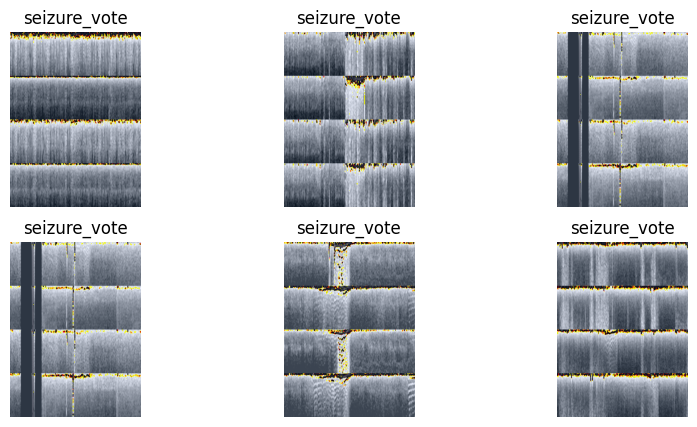

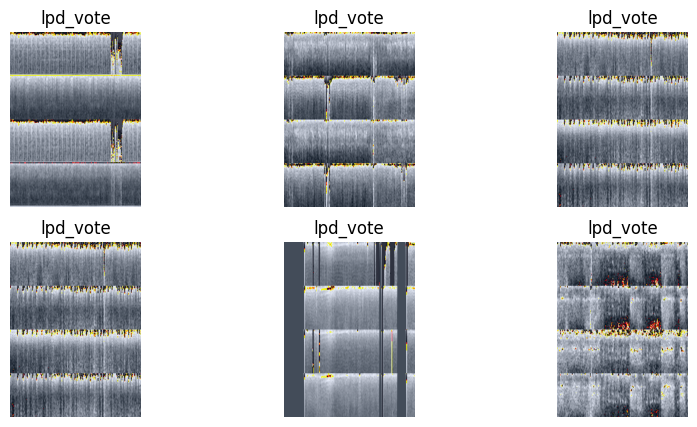

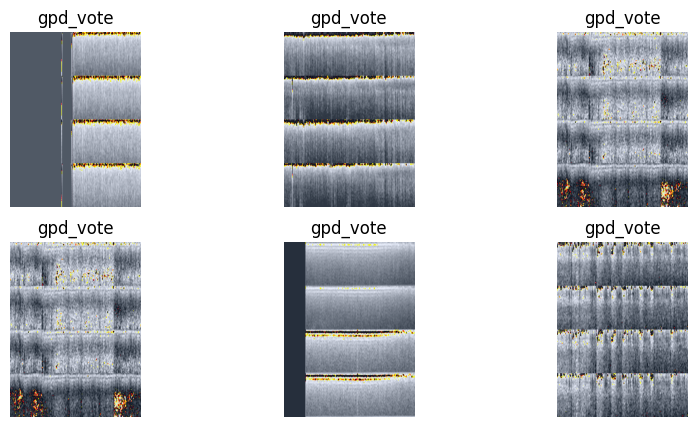

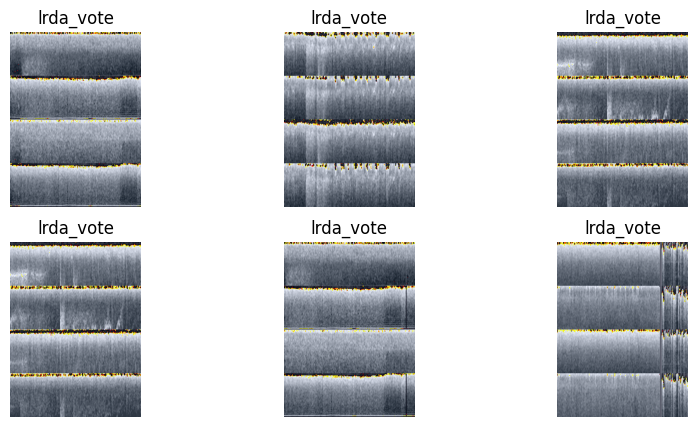

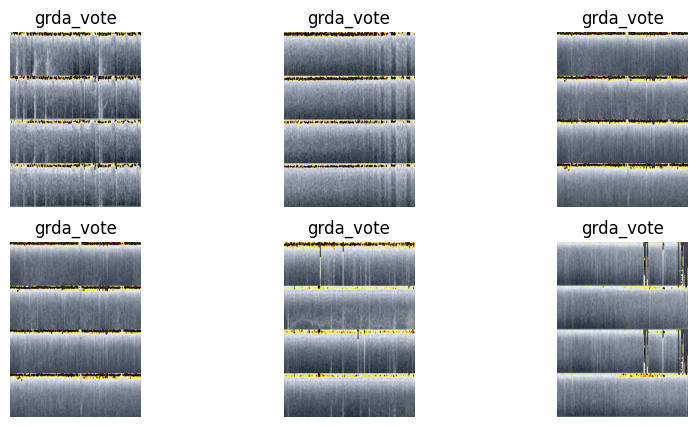

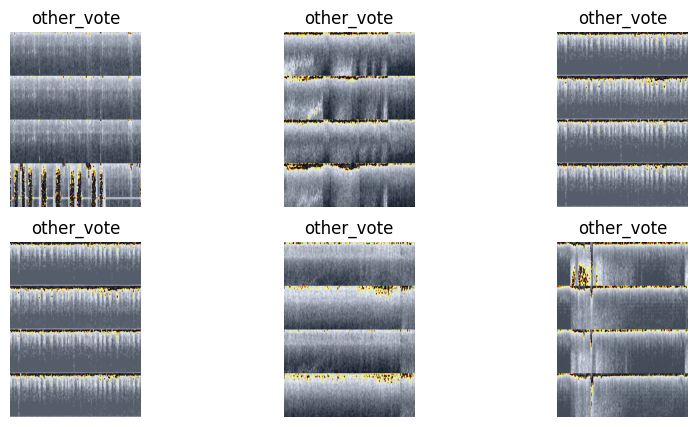

In [17]:
# sort the labels in accending order
label = np.argmax(class_votes, axis=1)
label, indices = torch.sort(label)
data = data[indices, :]
class_votes = class_votes[indices, :]

# image show data
for i in range(N_classes):
    size = 6
    # indices of items in the class
    idxs = np.where(label == i)[0]
    # image show data
    fig, ax = plt.subplots(2, size//2, figsize = (10,5))
    for j in range(size//2):
        for i in range(2):
            idx = idxs[i*2+j]
            img = ToPILImage()(data[idx, :])
            ax[i,j].imshow(img)
            ax[i,j].set_title(classes[label[idx]])
            ax[i,j].axis("off")

    plt.show()





## Define the Network Architecture


In [18]:
model_name = "CustomCNN" # "TransNet_Efficientnetb0" # "TransNet_Resnet18"


if model_name == "CustomCNN":
  model = CustomCNN(input_shape=input_shape, N_classes = N_classes)
elif model_name == "TransNet_Resnet18":
  model = TransNet_Resnet18(input_shape=input_shape, N_classes = N_classes)
elif model_name == "TransNet_Efficientnetb0":
  model = TransNet_Efficientnetb0(input_shape=input_shape, N_classes = N_classes)
else:
  raise ValueError("Model not found")

# index = 0
# path_model_old = f"./model_{model_name}_{index}.pt"
# model.load_state_dict(torch.load(path_model_old))

In [19]:
model

CustomCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=6, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [20]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [21]:
num_parameters = sum(p.numel() for p in model.parameters())
print('Number of parameters in the model', num_parameters)

# number of trainable parameters
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters in the model', num_parameters)

Number of parameters in the model 7404898
Number of trainable parameters in the model 7404898


### Specify [Loss Function](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html#torch.nn.KLDivLoss) and [Optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)


In [22]:
# check if "f"./model_{model_name}_*" exists and add 1 to the index
index = 0
while os.path.exists(f"./model_{model_name}_{index}.pt"):
    index += 1

configs = {'n_epochs':10,
           'path_model':f"./model_{model_name}_{index}.pt",
           'test': True,
}

configs


{'n_epochs': 10, 'path_model': './model_CustomCNN_0.pt', 'test': True}

## Learning rate scheduler

In [23]:
lr_start, lr_max, lr_min = 5e-4, 6e-5 * batch_size, 1e-4
lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

def lrfn(epoch, epochs, mode='cos'):  # Learning rate update function
    if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
    elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
    elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
    elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
    elif mode == 'cos':
        decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
        phase = np.pi * decay_epoch_index / decay_total_epochs
        lr = (lr_max - lr_min) * 0.5 * (1 + np.cos(phase)) + lr_min
    return lr

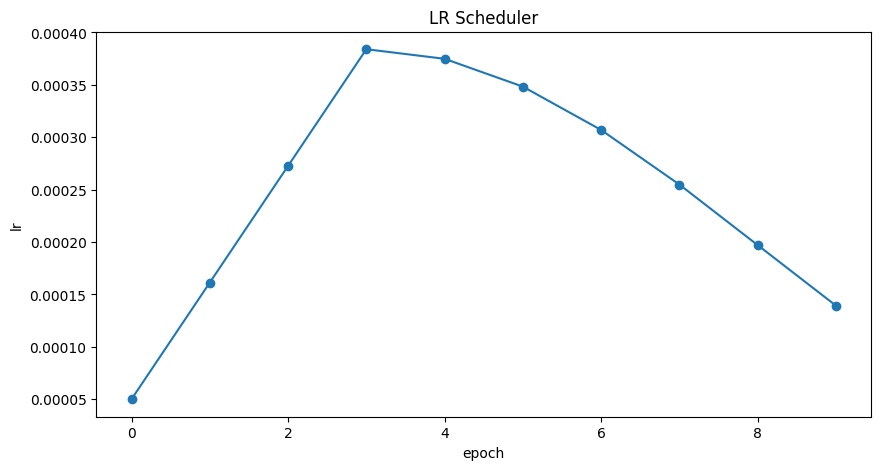

In [24]:
# Plot lr curve if plot is True
plt.figure(figsize=(10, 5))
plt.plot(np.arange(configs['n_epochs']), [lrfn(epoch, configs['n_epochs']) for epoch in np.arange(configs['n_epochs'])], marker='o')
plt.xlabel('epoch'); plt.ylabel('lr')
plt.title('LR Scheduler')
plt.show()

In [25]:
def train(model, train_loader, valid_loader, path_model, n_epochs, test):
    criterion = nn.KLDivLoss(reduction="batchmean",log_target= True)
    optimizer = optim.Adam(model.parameters())



    track_loss = []
    track_loss_val = []

    valid_loss_min = np.Inf # track change in validation loss

    max_samples = 5

    print('Epoch: \tTraining Loss:  \tValidation Loss:')
    for epoch in range(1, n_epochs+1):

        for g in optimizer.param_groups:
          g['lr'] = lrfn(epoch, n_epochs)
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        count = 0

        for data, votes in tqdm(train_loader):
            if test and count >= max_samples:
                break

            data, votes = get_batch_transform(data, votes)
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, votes = data.cuda(), votes.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # loss
            loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

            count +=1


        torch.cuda.empty_cache()
        ######################
        # validate the model #
        ######################
        model.eval()
        count = 0
        for data, votes in tqdm(valid_loader):
            if test and count >= max_samples:
                break

            data, votes = get_batch_transform(data, votes)
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, votes = data.cuda(), votes.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
            # update average validation loss
            valid_loss += loss.item()*data.size(0)

            count +=1


        torch.cuda.empty_cache()
        # calculate average losses
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)

        track_loss.append(train_loss)
        track_loss_val.append(valid_loss)

        # print training/validation statistics
        print('{}; \t{:.6f}; \t{:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), path_model)
            valid_loss_min = valid_loss

        gc.collect()

    return track_loss, track_loss_val

In [26]:
track_loss, track_loss_val = train(model, train_loader, valid_loader, **configs)

Epoch: 	Training Loss:  	Validation Loss:


  1%|▏         | 5/341 [00:22<24:43,  4.41s/it]


1; 	0.341268; 	1.043195


  1%|▏         | 5/341 [00:00<00:57,  5.80it/s]


2; 	0.341237; 	1.047110


  1%|▏         | 5/341 [00:00<00:53,  6.22it/s]


3; 	0.338630; 	1.050140


  1%|▏         | 5/341 [00:00<00:53,  6.25it/s]


4; 	0.336146; 	1.044448


  1%|▏         | 5/341 [00:00<00:57,  5.88it/s]


5; 	0.341595; 	1.046836


  1%|▏         | 5/341 [00:00<00:53,  6.33it/s]


6; 	0.336221; 	1.046990


  1%|▏         | 5/341 [00:00<00:54,  6.22it/s]


7; 	0.336971; 	1.046155


  1%|▏         | 5/341 [00:00<00:54,  6.19it/s]


8; 	0.333160; 	1.045031


  1%|▏         | 5/341 [00:00<01:00,  5.54it/s]


9; 	0.334035; 	1.044491


  1%|▏         | 5/341 [00:00<00:56,  5.97it/s]


10; 	0.333101; 	1.044466


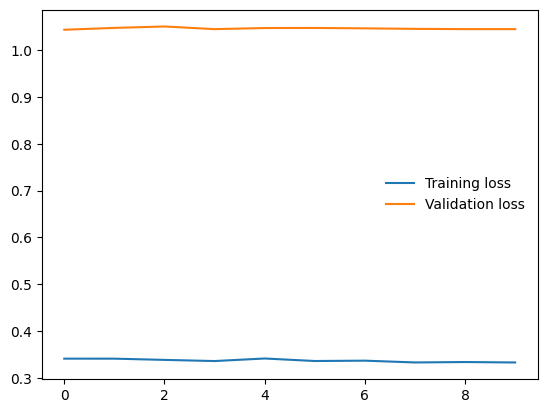

In [27]:
# plot the training and validation loss
plt.plot(track_loss, label='Training loss')
plt.plot(track_loss_val, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [28]:
model.load_state_dict(torch.load(configs['path_model']))

<All keys matched successfully>

In [29]:
data_path = path+'test/'
N_items = len(os.listdir(data_path)) // 2
print("Number of items", N_items)

test_data = CustomDataset(data_path = data_path, N_items = N_items)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=num_workers)

Number of items 305


In [30]:
criterion = nn.KLDivLoss(reduction="batchmean",log_target= True)

# track test loss
test_loss = 0.0
test_loss_baseline = 0.0
class_correct = list(0. for i in range(N_classes))
class_total = list(0. for i in range(N_classes))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()

max_samples = 1
cm_y_pred = []
cm_y_true = []
# iterate over test data
count = 0
for data, votes in tqdm(test_loader):
    if configs['test'] and count >= max_samples:
      break
    count+=1

    data, votes = get_batch_transform(data, votes)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, votes = data.cuda(), votes.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
    # dummy is a tensor filled with 1/6 of shape [64,6]
    dummy = torch.ones(data.size(0), N_classes).to(device)
    dummy = dummy/N_classes
    loss_baseline = criterion(output.float(), F.log_softmax(dummy, dim=1))
    # update test loss
    test_loss += loss.item()*data.size(0)
    test_loss_baseline += loss_baseline.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    target = np.argmax(votes, axis=1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

        cm_y_pred.append(pred[i].item())
        cm_y_true.append(target.data[i].item())

# average test loss
print()
test_loss = test_loss/len(test_loader.dataset)#/batch_size#/max_samples/0.1#
print('Test Loss: {:.6f}\n'.format(test_loss))

test_loss_baseline = test_loss_baseline/len(test_loader.dataset)#/batch_size#/max_samples/0.1#
print('Test Loss Baseline: {:.6f}\n'.format(test_loss_baseline))


  0%|          | 0/305 [00:03<?, ?it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
for i in range(N_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(cm_y_true, cm_y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='Blues')
plt.xticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

